<a href="https://colab.research.google.com/github/apugoneappu/experiments/blob/master/image_reconstruction/image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/apugoneappu/experiments.git

fatal: destination path 'experiments' already exists and is not an empty directory.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
img = cv2.imread('experiments/image_reconstruction/hdr.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(319, 500, 3)


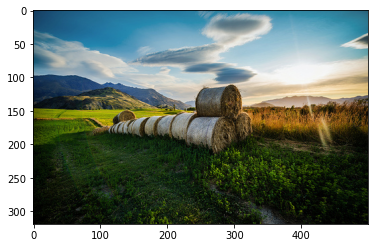

In [4]:
print(img.shape)
plt.imshow(img)

In [5]:
# Datalaoder 

from functools import reduce
import math

class Data(torch.utils.data.Dataset):

    def __init__(self, img):
        """
            img should be numpy array with shape (height, width , channels). eg - img of shape (10, 20, 3)
        """

        self.img = img/255.0
        self.rows, self.cols, self.channels = self.img.shape
        self.num_coords = self.rows * self.cols

    def __len__(self):
        """
            returns the number of coordinate pairs for self.image (10 * 20)
        """
        return self.num_coords

    def __getitem__(self, idx):
        """
            all returned values are scaled to [0,1]
            row, col, and the value of the image at (row, col)
        """

        row = math.floor(idx/self.cols)
        col = idx - (row*self.cols)

        img_color = self.img[row, col]

        return np.array([row/self.rows, col/self.cols], dtype=np.float32), img_color.astype(np.float32)

In [7]:
dataset = Data(img)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [9]:
# Test Dataset
rows, cols = img.shape[0], img.shape[1]
for idx in range(len(dataset)):

    # Orig colors
    r = math.floor(idx/cols)
    c = idx - (r*cols)
    color = img[r, c]

    inputs, ret_color = dataset[idx]
    ret_r = round(inputs[0] * rows)
    ret_c = round(inputs[1] * cols)

    assert abs(ret_r - r) == 0, print(f"ROW returned: {ret_r} orig: {r}")
    assert abs(ret_c - c) == 0, print(f"COLS returned: {ret_c} orig: {c}")
    assert (abs(ret_color * 255.0 - img[r,c]) == 0.0).all(), print(f"COLOR returned: {ret_color * 255.0} orig: {img[r,c]}")

In [7]:
for idx, data in enumerate(dataloader):
    inputs, colors = data
    print(inputs.shape)
    print(colors.shape)
    break

torch.Size([128, 2])
torch.Size([128, 3])


In [44]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):

        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 8)
        self.bn1 = nn.BatchNorm1d(8)

        self.fc2 = nn.Linear(8, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.fc4 = nn.Linear(128, 256)
        self.bn4 = nn.BatchNorm1d(256)

        self.fc5 = nn.Linear(256, 512)
        self.bn5 = nn.BatchNorm1d(512)

        self.fc6 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)

        self.fc7 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)

        self.fc8 = nn.Linear(128, 64)
        self.bn8 = nn.BatchNorm1d(64)

        self.fc9 = nn.Linear(64, 3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = self.relu(x)

        x = self.fc6(x)
        x = self.bn6(x)
        x = self.relu(x)

        x = self.fc7(x)
        x = self.bn7(x)
        x = self.relu(x)

        x = self.fc8(x)
        x = self.bn8(x)
        x = self.relu(x)

        x = self.fc9(x)
        x = self.sigmoid(x)

        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net()
net = net.to(device)

cuda:0


In [45]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

In [46]:
len(dataloader)

1247

In [63]:
class Vis:

    def __init__(self):

        self.images = []
        self.num_times = 0

    def __call__(self, net):
        new_img = np.zeros_like(img)
        dl = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)

        for idx, batch_data in enumerate(dl):

            inputs, colors = batch_data
            inputs = inputs.to(device)
            colors = colors.to(device)
            
            orig_colour = torch.round((colors*255.0)).cpu().numpy().astype(np.int32)
            ret_colour = torch.round((net(inputs)*255.0)).detach().cpu().numpy()

            inputs[:,0] *= dataset.rows
            inputs[:,1] *= dataset.cols

            inputs = torch.round(inputs).cpu().numpy().astype(np.int32)

            new_img[inputs[:,0], inputs[:,1],:] = ret_colour
        
        self.images.append(new_img)
        self.num_times += 1
        print(f"Called {self.num_times} times")

vis = Vis()

Called 1 times


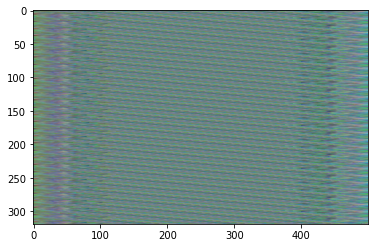

In [64]:
vis(net)
plt.imshow(vis.images[-1])

In [12]:
EPOCHS = 100

In [13]:
for epoch in range(EPOCHS):  # loop over the dataset multiple times

    vis(net)
    
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
    

print('Finished Training')

Called 1 times
[1,   200] loss: 0.01962
[1,   400] loss: 0.01649
[1,   600] loss: 0.01477
[1,   800] loss: 0.01461
[1,  1000] loss: 0.01447
[1,  1200] loss: 0.01364
Called 2 times
[2,   200] loss: 0.01399
[2,   400] loss: 0.01412
[2,   600] loss: 0.01303
[2,   800] loss: 0.01346
[2,  1000] loss: 0.01327
[2,  1200] loss: 0.01368
Called 3 times
[3,   200] loss: 0.01342
[3,   400] loss: 0.01334
[3,   600] loss: 0.01249
[3,   800] loss: 0.01302
[3,  1000] loss: 0.01310
[3,  1200] loss: 0.01259
Called 4 times
[4,   200] loss: 0.01215
[4,   400] loss: 0.01244
[4,   600] loss: 0.01312
[4,   800] loss: 0.01219
[4,  1000] loss: 0.01182
[4,  1200] loss: 0.01213
Called 5 times
[5,   200] loss: 0.01201
[5,   400] loss: 0.01129
[5,   600] loss: 0.01172
[5,   800] loss: 0.01161
[5,  1000] loss: 0.01166
[5,  1200] loss: 0.01122
Called 6 times
[6,   200] loss: 0.01109
[6,   400] loss: 0.01105
[6,   600] loss: 0.01104
[6,   800] loss: 0.01098
[6,  1000] loss: 0.01092
[6,  1200] loss: 0.01083
Called 7 t

KeyboardInterrupt: ignored

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %
